# Self Normalizing Neural Net

Before people came up with ideas such as batchnorm and smarter initializations for the weights of Deep Neural Networks, exploding and vanishing gradients were very problematic.

Here, we'll implement a self normalizing neural net that (without BN) is going to preserve the scales of its values troughout the net as in [Klambauer et al. (2017)](https://papers.nips.cc/paper_files/paper/2017/file/5d44ee6f2c3f71b73125876103c8f6c4-Paper.pdf)


In [4]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.callbacks as callbacks
import matplotlib.pyplot as plt
import numpy as np
import keras.layers

In [2]:
(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.cifar10.load_data()

In [3]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [120]:
def buildModel(nHiddenLayers=20, nHiddenNeurons=100):
    inputLayer = layers.Input(shape=(32, 32, 3))
    x = layers.Flatten()(inputLayer)
    for _ in range(nHiddenLayers):
        x = layers.Dense(nHiddenNeurons, 
                         kernel_initializer="he_normal",
                         activation="swish")(x)
    outputLayer = layers.Dense(10, activation="softmax")(x)
    return tf.keras.Model(inputLayer, outputLayer)

In [121]:
model = buildModel()

In [122]:
class ExpLearningRate(callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.lossi = []
    def on_batch_end(self, batch, logs=None):
        if np.isnan(logs["loss"]):
            print(f"\nTraining stopped: NaN loss detected at batch {batch}.\n")
            self.model.stop_training = True
        lr = self.model.optimizer.learning_rate.numpy() * (1 + self.factor / 100)
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.lossi.append(logs["loss"])

In [123]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])
expLR = ExpLearningRate(factor=1) # increase lr 1% each epoch

In [124]:
history = model.fit(xTrain, yTrain, epochs=1,
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[expLR])

1250/1250 [==============================] - 37s 26ms/step - loss: 3014.3003 - accuracy: 0.1107 - val_loss: 2.3814 - val_accuracy: 0.1016


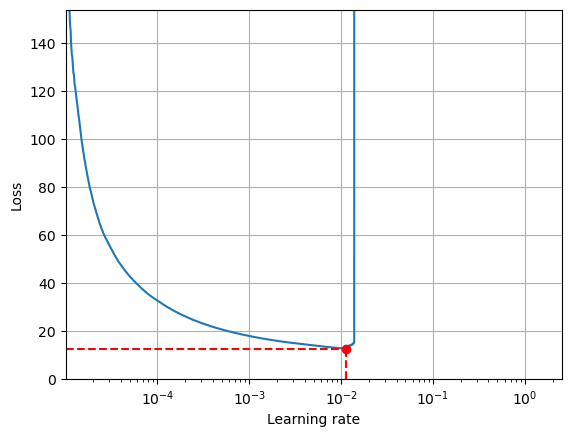

In [125]:
plt.plot(expLR.rates, expLR.lossi)
plt.gca().set_xscale('log')
plt.hlines([min(expLR.lossi)], 
           min(expLR.rates), expLR.rates[np.argmin(expLR.lossi)],"r", linestyles="--")
plt.vlines([expLR.rates[np.argmin(expLR.lossi)]], 
           0, min(expLR.lossi), "r", linestyles="--")
plt.plot(expLR.rates[np.argmin(expLR.lossi)], min(expLR.lossi), "ro")
plt.axis([min(expLR.rates), max(expLR.rates), 0, expLR.lossi[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss");

In [126]:
optimLR = expLR.rates[np.argmin(expLR.lossi)] / 2
optimLR

0.005677822078578174

In [127]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = buildModel()

early_stopping_cb = callbacks.EarlyStopping(patience=5,
                                            restore_best_weights=True)
model_checkpoint_cb = callbacks.ModelCheckpoint("my_cifar10_model.keras",
                                                save_best_only=True)

optimizer = tf.keras.optimizers.Nadam(learning_rate=optimLR)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(xTrain, yTrain, epochs=100,
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[early_stopping_cb, model_checkpoint_cb])

Epoch 1/100
1250/1250 [==============================] - 47s 33ms/step - loss: 9.9387 - accuracy: 0.2196 - val_loss: 1.9568 - val_accuracy: 0.2617
Epoch 2/100
1250/1250 [==============================] - 28s 22ms/step - loss: 1.9872 - accuracy: 0.2526 - val_loss: 1.9369 - val_accuracy: 0.2786
Epoch 3/100
1250/1250 [==============================] - 25s 20ms/step - loss: 1.9145 - accuracy: 0.2873 - val_loss: 1.8856 - val_accuracy: 0.2988
Epoch 4/100
1250/1250 [==============================] - 27s 22ms/step - loss: 1373.8926 - accuracy: 0.1854 - val_loss: 2.3133 - val_accuracy: 0.0979
Epoch 5/100
1250/1250 [==============================] - 35s 28ms/step - loss: 2.7730 - accuracy: 0.1022 - val_loss: 2.3033 - val_accuracy: 0.1003
Epoch 6/100
1250/1250 [==============================] - 34s 28ms/step - loss: 2.3035 - accuracy: 0.0979 - val_loss: 2.3036 - val_accuracy: 0.0952
Epoch 7/100
1250/1250 [==============================] - 33s 27ms/step - loss: 2.3033 - accuracy: 0.1004 - val_loss

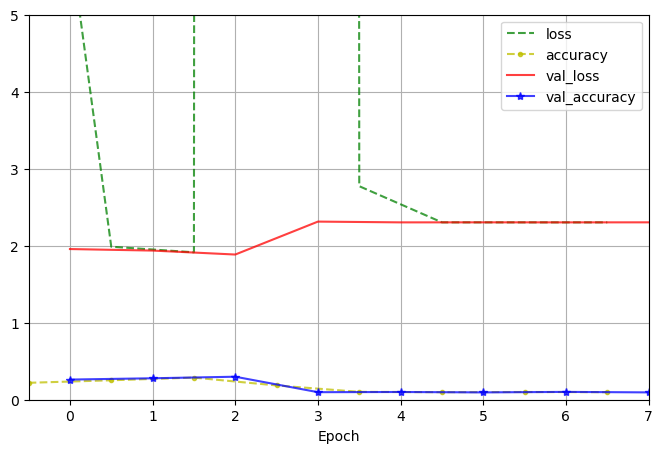

In [156]:
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["g--", "y--.", "r-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key, alpha=0.75)
plt.xlabel("Epoch")
plt.axis([-0.5, 7, 0., 5])
plt.legend()
plt.grid()
plt.show()

The model doesn't converge even though we've set the learning rate to be the recommended (half of the lr when the loss starts to grow to infinity in the last plot). This is due to the network not having anything to normalize its values, thus, the gradients are very unstable. Let's try with a smaller learning rate.

In [157]:
optimLR /= 10

tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = buildModel()

early_stopping_cb = callbacks.EarlyStopping(patience=5,
                                            restore_best_weights=True)
model_checkpoint_cb = callbacks.ModelCheckpoint("my_cifar10_model.keras",
                                                save_best_only=True)

optimizer = tf.keras.optimizers.Nadam(learning_rate=optimLR)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(xTrain, yTrain, epochs=100,
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[early_stopping_cb, model_checkpoint_cb])

Epoch 1/100
1250/1250 [==============================] - 47s 25ms/step - loss: 2.9665 - accuracy: 0.2114 - val_loss: 1.9904 - val_accuracy: 0.2534
Epoch 2/100
1250/1250 [==============================] - 35s 28ms/step - loss: 1.9447 - accuracy: 0.2721 - val_loss: 1.8733 - val_accuracy: 0.3116
Epoch 3/100
1250/1250 [==============================] - 30s 24ms/step - loss: 1.8799 - accuracy: 0.3034 - val_loss: 1.9243 - val_accuracy: 0.2867
Epoch 4/100
1250/1250 [==============================] - 38s 31ms/step - loss: 1.8418 - accuracy: 0.3207 - val_loss: 1.8186 - val_accuracy: 0.3230
Epoch 5/100
1250/1250 [==============================] - 31s 25ms/step - loss: 1.8067 - accuracy: 0.3364 - val_loss: 1.7865 - val_accuracy: 0.3495
Epoch 6/100
1250/1250 [==============================] - 26s 21ms/step - loss: 1.7791 - accuracy: 0.3515 - val_loss: 1.8219 - val_accuracy: 0.3468
Epoch 7/100
1250/1250 [==============================] - 30s 24ms/step - loss: 1.7480 - accuracy: 0.3649 - val_loss: 1

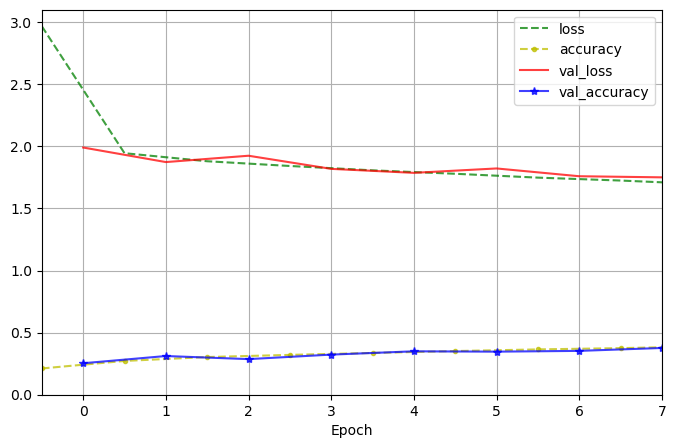

In [159]:
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["g--", "y--.", "r-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key, alpha=0.75)
plt.xlabel("Epoch")
plt.axis([-0.5, 7, 0., 3.1])
plt.legend()
plt.grid()
plt.show()

Much better, we could try decreasing the LR a bit more or using a scheduler but now let's try to use Batch normalization and see if it helps convergence.

In [162]:
def buildBNModel(nHiddenLayers=20, nHiddenNeurons=100):
    inputLayer = layers.Input(shape=(32, 32, 3))
    x = layers.Flatten()(inputLayer)
    for _ in range(nHiddenLayers):
        x = layers.Dense(nHiddenNeurons, 
                         kernel_initializer="he_normal")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("swish")(x)
    outputLayer = layers.Dense(10, activation="softmax")(x)
    return tf.keras.Model(inputLayer, outputLayer)

In [166]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = buildBNModel()

optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

expLR = ExpLearningRate(factor=1)

history = model.fit(xTrain, yTrain, epochs=3,
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[expLR])

Epoch 1/3
1250/1250 [==============================] - 47s 27ms/step - loss: 2.3459 - accuracy: 0.1545 - val_loss: 368280.0938 - val_accuracy: 0.0994
Epoch 2/3
1250/1250 [==============================] - 34s 27ms/step - loss: 10449327104.0000 - accuracy: 0.1013 - val_loss: 414105147359100928.0000 - val_accuracy: 0.0952
Epoch 3/3
1250/1250 [==============================] - 36s 29ms/step - loss: 6232538624.0000 - accuracy: 0.1002 - val_loss: 86343892992.0000 - val_accuracy: 0.0952


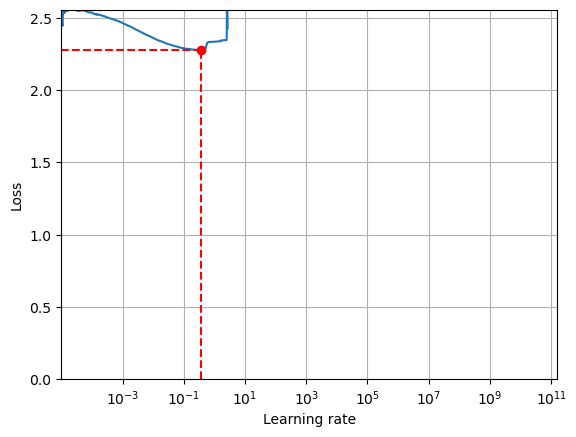

In [168]:
plt.plot(expLR.rates, expLR.lossi)
plt.gca().set_xscale('log')
plt.hlines([min(expLR.lossi)], 
           min(expLR.rates), expLR.rates[np.argmin(expLR.lossi)],"r", linestyles="--")
plt.vlines([expLR.rates[np.argmin(expLR.lossi)]], 
           0, min(expLR.lossi), "r", linestyles="--")
plt.plot(expLR.rates[np.argmin(expLR.lossi)], min(expLR.lossi), "ro")
plt.axis([min(expLR.rates), max(expLR.rates), 0, expLR.lossi[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss");

I've noticed that the approach of halving the max learning rate is not working properly, as the model doesn't get good performances or directly diverges. This time, I'll try to divide by 100

In [173]:
optimLR = expLR.rates[np.argmin(expLR.lossi)] / 100
optimLR

0.0036228447884321213

In [174]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = buildBNModel()

early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            restore_best_weights=True)
model_checkpoint_cb = callbacks.ModelCheckpoint("my_cifar10_model_bn.keras",
                                                save_best_only=True)

optimizer = tf.keras.optimizers.Nadam(learning_rate=optimLR)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(xTrain, yTrain, epochs=100,
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[early_stopping_cb, model_checkpoint_cb])

Epoch 1/100
1250/1250 [==============================] - 58s 36ms/step - loss: 1.9707 - accuracy: 0.2709 - val_loss: 2.1168 - val_accuracy: 0.2583
Epoch 2/100
1250/1250 [==============================] - 49s 39ms/step - loss: 1.7731 - accuracy: 0.3603 - val_loss: 2.0689 - val_accuracy: 0.3171
Epoch 3/100
1250/1250 [==============================] - 45s 36ms/step - loss: 1.6987 - accuracy: 0.3910 - val_loss: 1.8686 - val_accuracy: 0.3665
Epoch 4/100
1250/1250 [==============================] - 63s 51ms/step - loss: 1.6475 - accuracy: 0.4091 - val_loss: 1.7359 - val_accuracy: 0.3965
Epoch 5/100
1250/1250 [==============================] - 43s 35ms/step - loss: 1.5964 - accuracy: 0.4324 - val_loss: 2.2812 - val_accuracy: 0.2891
Epoch 6/100
1250/1250 [==============================] - 37s 30ms/step - loss: 1.5554 - accuracy: 0.4451 - val_loss: 1.8586 - val_accuracy: 0.3463
Epoch 7/100
1250/1250 [==============================] - 56s 45ms/step - loss: 1.5168 - accuracy: 0.4621 - val_loss: 1

Using this smaller learning rate provides much better results. On top of this, applying batch normalization seems to have helped a lot as now the model takes just 9 epochs to surpass the best validation accuracy obtained by the model without BN (note that for that model we used a similar lr)

Also note that it takes more time to train each epoch but the results are better and the convergence is way faster! 

## Now time for the self normalizing neural net

For the net to self normalize we have to change some details of our model:
* The activation functions must be SELU
* The initialization of the weights must be set to "lecun_normal"
* We have to standardize the inputs

In [5]:
optimLR = 0.0003
def buildSNModel(nHiddenLayers=20, nHiddenNeurons=100):
    inputLayer = layers.Input(shape=(32, 32, 3))
    x = layers.Flatten()(inputLayer)
    for _ in range(nHiddenLayers):
        x = layers.Dense(nHiddenNeurons, 
                         kernel_initializer="lecun_normal")(x)
        x = layers.Activation("selu")(x)
    outputLayer = layers.Dense(10, activation="softmax")(x)
    return tf.keras.Model(inputLayer, outputLayer)

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = buildSNModel()

early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            restore_best_weights=True)
model_checkpoint_cb = callbacks.ModelCheckpoint("my_cifar10_model_sn.keras",
                                                save_best_only=True)

xMeans = xTrain.mean(axis=0)
xStds = xTrain.std(axis=0)
xTrainScaled = (xTrain - xMeans) / xStds
xTestScaled = (xTest - xMeans) / xStds

optimizer = tf.keras.optimizers.Nadam(learning_rate=optimLR)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(xTrainScaled, yTrain, epochs=100,
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[early_stopping_cb, model_checkpoint_cb])

2024-10-22 14:25:57.826064: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/100
1250/1250 [==============================] - 35s 23ms/step - loss: 1.8660 - accuracy: 0.3355 - val_loss: 1.7401 - val_accuracy: 0.3725
Epoch 2/100
1250/1250 [==============================] - 56s 45ms/step - loss: 1.6620 - accuracy: 0.4112 - val_loss: 1.6436 - val_accuracy: 0.4210
Epoch 3/100
1250/1250 [==============================] - 41s 33ms/step - loss: 1.5628 - accuracy: 0.4453 - val_loss: 1.5860 - val_accuracy: 0.4397
Epoch 4/100
1250/1250 [==============================] - 42s 33ms/step - loss: 1.4933 - accuracy: 0.4710 - val_loss: 1.5566 - val_accuracy: 0.4455
Epoch 5/100
1250/1250 [==============================] - 45s 36ms/step - loss: 1.4277 - accuracy: 0.4944 - val_loss: 1.5283 - val_accuracy: 0.4622
Epoch 6/100
1250/1250 [==============================] - 24s 19ms/step - loss: 1.3725 - accuracy: 0.5147 - val_loss: 1.4890 - val_accuracy: 0.4791
Epoch 7/100
1250/1250 [==============================] - 38s 31ms/step - loss: 1.3168 - accuracy: 0.5365 - val_loss: 1

This is the model that yields the best results. Even though it's supposed to be faster to train (because it doesn't perform the BN calculations), I belive it took similar time as the BN model because I was using my computer while it was training. Still, the convergence is faster

The model is overfitting the dataset (we got 63% accuracy in the train set and just 45% in the val), so let's apply Dropout as a regulizer. Note that for the network to keep its self-normalization ability we have to use AlphaDropout instead of the regular one, this helps keep the means and variances under control troughout the net.

Apparently the AlphaDropout layer from tensorflow is broken so I will try with the keras version. Also, I noticed that adding a dropout layer after each dense layer makes the model underfit the data, so we'll just add a couple layers.

In [7]:
dropoutRate = 0.1
def buildSNModelDO(nHiddenLayers=20, nHiddenNeurons=100):
    inputLayer = layers.Input(shape=(32, 32, 3))
    x = layers.Flatten()(inputLayer)
    x = layers.Dense(nHiddenNeurons, 
                     kernel_initializer="lecun_normal")(x)
    x = layers.Activation("selu")(x)
    x = keras.layers.AlphaDropout(dropoutRate)(x)
    for _ in range(nHiddenLayers):
        x = layers.Dense(nHiddenNeurons, 
                         kernel_initializer="lecun_normal")(x)
        x = layers.Activation("selu")(x)
    x = keras.layers.AlphaDropout(dropoutRate)(x)
    outputLayer = layers.Dense(10, activation="softmax")(x)
    return tf.keras.Model(inputLayer, outputLayer)

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = buildSNModelDO()

early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            restore_best_weights=True)
model_checkpoint_cb = callbacks.ModelCheckpoint("my_cifar10_model_sn_do.keras",
                                                save_best_only=True)

optimizer = tf.keras.optimizers.Nadam(learning_rate=optimLR)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(xTrainScaled, yTrain, epochs=100,
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[early_stopping_cb, model_checkpoint_cb])

Epoch 1/100
1250/1250 [==============================] - 48s 35ms/step - loss: 1.9568 - accuracy: 0.3016 - val_loss: 1.7663 - val_accuracy: 0.3769
Epoch 2/100
1250/1250 [==============================] - 28s 22ms/step - loss: 1.7183 - accuracy: 0.3881 - val_loss: 1.7124 - val_accuracy: 0.4013
Epoch 3/100
1250/1250 [==============================] - 31s 24ms/step - loss: 1.6331 - accuracy: 0.4201 - val_loss: 1.6255 - val_accuracy: 0.4372
Epoch 4/100
1250/1250 [==============================] - 32s 25ms/step - loss: 1.5721 - accuracy: 0.4435 - val_loss: 1.6466 - val_accuracy: 0.4366
Epoch 5/100
1250/1250 [==============================] - 30s 24ms/step - loss: 1.5244 - accuracy: 0.4607 - val_loss: 1.6234 - val_accuracy: 0.4468
Epoch 6/100
1250/1250 [==============================] - 44s 35ms/step - loss: 1.4852 - accuracy: 0.4754 - val_loss: 1.5850 - val_accuracy: 0.4618
Epoch 7/100
1250/1250 [==============================] - 43s 35ms/step - loss: 1.4452 - accuracy: 0.4918 - val_loss: 1

We can define a new function to apply Monte Carlo Dropout, we don't have to train the model again, just call it in training mode to make several predictions and then average them.

In [9]:
def mcDropoutProbs(mc_model, X, nSamples=10):
    Y_probas = [mc_model(X, training=True) for sample in range(nSamples)]
    return np.mean(Y_probas, axis=0)

def mcDropoutClass(mc_model, X, nSamples=10):
    Y_probas = mcDropoutProbs(mc_model, X, nSamples)
    return Y_probas.argmax(axis=1)

In [10]:
tf.random.set_seed(42)

y_pred = mcDropoutClass(model, xTrainScaled)
accuracy = (y_pred == yTrain[:, 0]).mean()
accuracy

0.60364

Lastly, let's try an scheduler for the training to see if we can get not only better accuracy but also faster training.